# fit_optimal_FCN

Using keras tuner (and different optimisers) to build optimal fully connected network

--- 

- Having tested basic FCN and CNNs (find_baseline_FCN & find_baseline_CNN), model accuracy is around 85% for both (FCN slightly better)
- Due to the small image size, the models tend to converge quickly and don't require a lot of complexity. 
- CNNs (partially due to augmentation which misrepresents actual data) can get stuck classifying everything as 'use' (which naturally gives an accuracy of 75%), even with weighting. 
- Indications of learning rate being too high due to fluctuations in accuracy (validation especially), so far only used ADAM but will tune hyperparameter (with ReduceLRonPlateu).


In [23]:
import keras 
import tensorflow as tf
import kerastuner as kt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import IPython 
from keras.callbacks import ReduceLROnPlateau


import model_constructors
import evaluate_model

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Loading in pre-processed data
- Using binary classifications [i.e. use 0 (don't use) or 1 (use)] due to intrinsic mixing between messy and clean classifications.
- Reshaping X data (i.e adding channel) for CNN input.

In [3]:
# see ../pre-processing/clean_dataset/ for more info
filepath = '/Users/chrisduckworth/projects/ML_portfolio/kin_mis_classification/CNN/pre-processing/clean_dataset_files/'

X_train = np.load(filepath + 'X_train.npy')
X_test = np.load(filepath + 'X_test.npy')
X_val = np.load(filepath + 'X_val.npy')

# adding dimension for CNN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_val = X_val[..., np.newaxis]

y_train = np.load(filepath + 'y_train_binary.npy')
y_test = np.load(filepath + 'y_test_binary.npy')
y_val = np.load(filepath + 'y_val_binary.npy')

### Plotting class counts
- Computing weights since there is a significant imbalance between the number of 0 and 1s.

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 1 0 ... 1 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 2.055411535968892, 1: 0.6607291666666667}

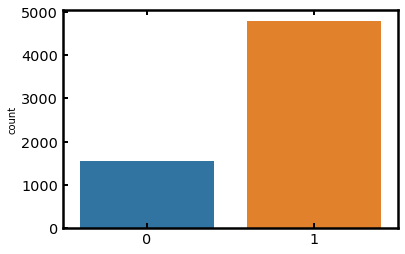

In [4]:
sns.countplot(y_train)

# computing class weights from sklearn and converting to dict (needed for keras input)
weight = class_weight.compute_class_weight('balanced', 
                                           np.unique(y_train),
                                           y_train)

weight = {i : weight[i] for i in np.arange(weight.shape[0])}
weight

In [5]:
train_gen = ImageDataGenerator(rotation_range = 180,  # randomly rotate images in the range (degrees, 0 to 180)
                               horizontal_flip = True, 
                               vertical_flip = True)  # randomly flip images

train_gen.fit(X_train)

### Hyperparameter tuning
- Three dense layers (each with its own dropout rate) units + D/O rate tuned for each
- Learning rate tuned (for input into Adam optimiser).

In [9]:
tuner = kt.Hyperband(model_constructors.build_tuning_sequential_FCN,
                     objective = 'val_accuracy', # model evaluation metric
                     max_epochs = 10, # The maximum number of epochs to train one model. 
                     factor = 3, # Reduction factor for the number of epochs and number of models for each bracket.
                     directory = './tuning',
                     project_name = 'FCN_tuning') 

# Before running the hyperparameter search, define a callback to clear the training outputs 
# at the end of every training step.
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

INFO:tensorflow:Reloading Oracle from existing project ./tuning/FCN_tuning/oracle.json
INFO:tensorflow:Reloading Tuner from ./tuning/FCN_tuning/tuner0.json


In [10]:
tuner.search(train_gen.flow(X_train, y_train), 
             epochs = 20, 
             validation_data = (X_val, y_val), 
             callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""The hyperparameter search is complete.
The optimal number of units are {best_hps.get('units_1'), best_hps.get('units_2'), best_hps.get('units_3')} respectively.
The optimal dropout rates are {best_hps.get('dropout_1'), best_hps.get('dropout_2'), best_hps.get('dropout_3')} respectively.
The optimal learning rate for the optimiser is {best_hps.get('learning_rate')}.""")

INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
The optimal number of units are (64, 128, 80) respectively.
The optimal dropout rates are (0.0, 0.6000000000000001, 0.5) respectively.
The optimal learning rate for the optimiser is 0.001.


In [82]:
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(train_gen.flow(X_train, y_train, batch_size=64), 
#                     epochs = 50, 
#                     validation_data = (X_val, y_val))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001)

model.fit(train_gen.flow(X_train, y_train, batch_size=64),
          validation_data=(X_val, y_val), 
          class_weight=weight, 
          callbacks = [reduce_lr],
          epochs=50)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.93 - ETA: 1s - loss: 0.3408 - accuracy: 0.87 - ETA: 1s - loss: 0.3458 - accuracy: 0.86 - ETA: 1s - loss: 0.3513 - accuracy: 0.86 - ETA: 1s - loss: 0.3416 - accuracy: 0.87 - ETA: 1s - loss: 0.3488 - accuracy: 0.86 - ETA: 0s - loss: 0.3626 - accuracy: 0.86 - ETA: 0s - loss: 0.3592 - accuracy: 0.86 - ETA: 0s - loss: 0.3603 - accuracy: 0.86 - ETA: 0s - loss: 0.3626 - accuracy: 0.86 - ETA: 0s - loss: 0.3530 - accuracy: 0.86 - ETA: 0s - loss: 0.3517 - accuracy: 0.86 - ETA: 0s - loss: 0.3490 - accuracy: 0.86 - ETA: 0s - loss: 0.3416 - accuracy: 0.86 - ETA: 0s - loss: 0.3384 - accuracy: 0.86 - ETA: 0s - loss: 0.3370 - accuracy: 0.87 - ETA: 0s - loss: 0.3391 - accuracy: 0.87 - ETA: 0s - loss: 0.3383 - accuracy: 0.87 - ETA: 0s - loss: 0.3373 - accuracy: 0.87 - ETA: 0s - loss: 0.3400 - accuracy: 0.87 - ETA: 0s - loss: 0.3386 - accuracy: 0.87 - ETA: 0s - loss: 0.3353 - accuracy: 0.87 - ETA: 0s - loss: 0.3356

100/100 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.90 - ETA: 1s - loss: 0.3352 - accuracy: 0.88 - ETA: 1s - loss: 0.3176 - accuracy: 0.89 - ETA: 1s - loss: 0.3204 - accuracy: 0.88 - ETA: 1s - loss: 0.3622 - accuracy: 0.87 - ETA: 1s - loss: 0.3603 - accuracy: 0.87 - ETA: 1s - loss: 0.3644 - accuracy: 0.87 - ETA: 0s - loss: 0.3673 - accuracy: 0.87 - ETA: 0s - loss: 0.3655 - accuracy: 0.87 - ETA: 0s - loss: 0.3522 - accuracy: 0.87 - ETA: 0s - loss: 0.3508 - accuracy: 0.87 - ETA: 0s - loss: 0.3501 - accuracy: 0.87 - ETA: 0s - loss: 0.3492 - accuracy: 0.87 - ETA: 0s - loss: 0.3446 - accuracy: 0.87 - ETA: 0s - loss: 0.3455 - accuracy: 0.87 - ETA: 0s - loss: 0.3431 - accuracy: 0.87 - ETA: 0s - loss: 0.3422 - accuracy: 0.87 - ETA: 0s - loss: 0.3414 - accuracy: 0.87 - ETA: 0s - loss: 0.3428 - accuracy: 0.87 - ETA: 0s - loss: 0.3410 - accuracy: 0.87 - ETA: 0s - loss: 0.3425 - accuracy: 0.87 - ETA: 0s - loss: 0.3438 - accuracy: 0.87 - ETA: 0s - loss: 0.3419 - accuracy

100/100 [==============================] - ETA: 0s - loss: 0.3839 - accuracy: 0.82 - ETA: 0s - loss: 0.3354 - accuracy: 0.86 - ETA: 0s - loss: 0.3310 - accuracy: 0.87 - ETA: 0s - loss: 0.3243 - accuracy: 0.87 - ETA: 0s - loss: 0.3285 - accuracy: 0.87 - ETA: 0s - loss: 0.3219 - accuracy: 0.88 - ETA: 0s - loss: 0.3185 - accuracy: 0.88 - ETA: 0s - loss: 0.3134 - accuracy: 0.88 - ETA: 0s - loss: 0.3146 - accuracy: 0.88 - ETA: 0s - loss: 0.3227 - accuracy: 0.88 - ETA: 0s - loss: 0.3315 - accuracy: 0.87 - ETA: 0s - loss: 0.3318 - accuracy: 0.87 - ETA: 0s - loss: 0.3326 - accuracy: 0.87 - ETA: 0s - loss: 0.3322 - accuracy: 0.87 - ETA: 0s - loss: 0.3316 - accuracy: 0.87 - ETA: 0s - loss: 0.3322 - accuracy: 0.87 - ETA: 0s - loss: 0.3365 - accuracy: 0.87 - ETA: 0s - loss: 0.3401 - accuracy: 0.87 - ETA: 0s - loss: 0.3380 - accuracy: 0.87 - ETA: 0s - loss: 0.3337 - accuracy: 0.87 - ETA: 0s - loss: 0.3326 - accuracy: 0.87 - 1s 12ms/step - loss: 0.3315 - accuracy: 0.8769 - val_loss: 0.3246 - val_acc

100/100 [==============================] - ETA: 0s - loss: 0.4284 - accuracy: 0.90 - ETA: 0s - loss: 0.3463 - accuracy: 0.90 - ETA: 0s - loss: 0.3493 - accuracy: 0.90 - ETA: 0s - loss: 0.3341 - accuracy: 0.89 - ETA: 0s - loss: 0.3243 - accuracy: 0.89 - ETA: 0s - loss: 0.3327 - accuracy: 0.88 - ETA: 0s - loss: 0.3346 - accuracy: 0.88 - ETA: 0s - loss: 0.3240 - accuracy: 0.88 - ETA: 0s - loss: 0.3245 - accuracy: 0.88 - ETA: 0s - loss: 0.3278 - accuracy: 0.88 - ETA: 0s - loss: 0.3337 - accuracy: 0.88 - ETA: 0s - loss: 0.3296 - accuracy: 0.88 - ETA: 0s - loss: 0.3390 - accuracy: 0.88 - ETA: 0s - loss: 0.3387 - accuracy: 0.88 - ETA: 0s - loss: 0.3372 - accuracy: 0.88 - ETA: 0s - loss: 0.3382 - accuracy: 0.88 - ETA: 0s - loss: 0.3366 - accuracy: 0.88 - ETA: 0s - loss: 0.3378 - accuracy: 0.88 - ETA: 0s - loss: 0.3369 - accuracy: 0.88 - ETA: 0s - loss: 0.3392 - accuracy: 0.88 - ETA: 0s - loss: 0.3373 - accuracy: 0.88 - ETA: 0s - loss: 0.3348 - accuracy: 0.88 - 1s 13ms/step - loss: 0.3356 - acc

100/100 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.87 - ETA: 0s - loss: 0.3775 - accuracy: 0.86 - ETA: 0s - loss: 0.3378 - accuracy: 0.87 - ETA: 1s - loss: 0.3527 - accuracy: 0.86 - ETA: 1s - loss: 0.3494 - accuracy: 0.86 - ETA: 0s - loss: 0.3400 - accuracy: 0.87 - ETA: 0s - loss: 0.3489 - accuracy: 0.86 - ETA: 0s - loss: 0.3333 - accuracy: 0.87 - ETA: 0s - loss: 0.3309 - accuracy: 0.87 - ETA: 0s - loss: 0.3304 - accuracy: 0.87 - ETA: 0s - loss: 0.3298 - accuracy: 0.87 - ETA: 0s - loss: 0.3231 - accuracy: 0.87 - ETA: 0s - loss: 0.3275 - accuracy: 0.87 - ETA: 0s - loss: 0.3289 - accuracy: 0.87 - ETA: 0s - loss: 0.3248 - accuracy: 0.87 - ETA: 0s - loss: 0.3218 - accuracy: 0.87 - ETA: 0s - loss: 0.3235 - accuracy: 0.87 - ETA: 0s - loss: 0.3232 - accuracy: 0.87 - ETA: 0s - loss: 0.3267 - accuracy: 0.87 - ETA: 0s - loss: 0.3256 - accuracy: 0.87 - ETA: 0s - loss: 0.3255 - accuracy: 0.87 - ETA: 0s - loss: 0.3258 - accuracy: 0.87 - 1s 12ms/step - loss: 0.3262 - acc

100/100 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.82 - ETA: 1s - loss: 0.4788 - accuracy: 0.84 - ETA: 1s - loss: 0.3681 - accuracy: 0.87 - ETA: 1s - loss: 0.3723 - accuracy: 0.86 - ETA: 1s - loss: 0.3627 - accuracy: 0.86 - ETA: 0s - loss: 0.3518 - accuracy: 0.86 - ETA: 0s - loss: 0.3425 - accuracy: 0.86 - ETA: 0s - loss: 0.3430 - accuracy: 0.86 - ETA: 0s - loss: 0.3413 - accuracy: 0.86 - ETA: 0s - loss: 0.3550 - accuracy: 0.86 - ETA: 0s - loss: 0.3499 - accuracy: 0.86 - ETA: 0s - loss: 0.3476 - accuracy: 0.86 - ETA: 0s - loss: 0.3488 - accuracy: 0.86 - ETA: 0s - loss: 0.3478 - accuracy: 0.86 - ETA: 0s - loss: 0.3427 - accuracy: 0.87 - ETA: 0s - loss: 0.3418 - accuracy: 0.86 - ETA: 0s - loss: 0.3397 - accuracy: 0.87 - ETA: 0s - loss: 0.3402 - accuracy: 0.87 - ETA: 0s - loss: 0.3403 - accuracy: 0.87 - ETA: 0s - loss: 0.3385 - accuracy: 0.87 - ETA: 0s - loss: 0.3354 - accuracy: 0.87 - ETA: 0s - loss: 0.3353 - accuracy: 0.87 - ETA: 0s - loss: 0.3359 - accuracy

100/100 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.87 - ETA: 0s - loss: 0.2814 - accuracy: 0.89 - ETA: 0s - loss: 0.3083 - accuracy: 0.88 - ETA: 0s - loss: 0.3101 - accuracy: 0.88 - ETA: 0s - loss: 0.3111 - accuracy: 0.89 - ETA: 0s - loss: 0.3114 - accuracy: 0.88 - ETA: 0s - loss: 0.3132 - accuracy: 0.88 - ETA: 0s - loss: 0.3132 - accuracy: 0.88 - ETA: 0s - loss: 0.3177 - accuracy: 0.88 - ETA: 0s - loss: 0.3189 - accuracy: 0.88 - ETA: 0s - loss: 0.3196 - accuracy: 0.88 - ETA: 0s - loss: 0.3224 - accuracy: 0.88 - ETA: 0s - loss: 0.3237 - accuracy: 0.88 - ETA: 0s - loss: 0.3254 - accuracy: 0.88 - ETA: 0s - loss: 0.3302 - accuracy: 0.87 - ETA: 0s - loss: 0.3397 - accuracy: 0.87 - ETA: 0s - loss: 0.3387 - accuracy: 0.87 - ETA: 0s - loss: 0.3371 - accuracy: 0.87 - ETA: 0s - loss: 0.3381 - accuracy: 0.87 - ETA: 0s - loss: 0.3381 - accuracy: 0.87 - ETA: 0s - loss: 0.3373 - accuracy: 0.87 - ETA: 0s - loss: 0.3354 - accuracy: 0.87 - ETA: 0s - loss: 0.3383 - accuracy

100/100 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.92 - ETA: 0s - loss: 0.2478 - accuracy: 0.91 - ETA: 1s - loss: 0.2673 - accuracy: 0.89 - ETA: 1s - loss: 0.2968 - accuracy: 0.88 - ETA: 1s - loss: 0.3026 - accuracy: 0.88 - ETA: 1s - loss: 0.2946 - accuracy: 0.88 - ETA: 1s - loss: 0.3038 - accuracy: 0.88 - ETA: 0s - loss: 0.3133 - accuracy: 0.88 - ETA: 0s - loss: 0.3166 - accuracy: 0.88 - ETA: 0s - loss: 0.3145 - accuracy: 0.88 - ETA: 0s - loss: 0.3197 - accuracy: 0.87 - ETA: 0s - loss: 0.3190 - accuracy: 0.87 - ETA: 0s - loss: 0.3178 - accuracy: 0.88 - ETA: 0s - loss: 0.3210 - accuracy: 0.88 - ETA: 0s - loss: 0.3211 - accuracy: 0.88 - ETA: 0s - loss: 0.3254 - accuracy: 0.88 - ETA: 0s - loss: 0.3236 - accuracy: 0.88 - ETA: 0s - loss: 0.3221 - accuracy: 0.88 - ETA: 0s - loss: 0.3219 - accuracy: 0.88 - ETA: 0s - loss: 0.3233 - accuracy: 0.87 - ETA: 0s - loss: 0.3230 - accuracy: 0.88 - ETA: 0s - loss: 0.3239 - accuracy: 0.88 - ETA: 0s - loss: 0.3232 - accuracy

(0.7, 0.9)

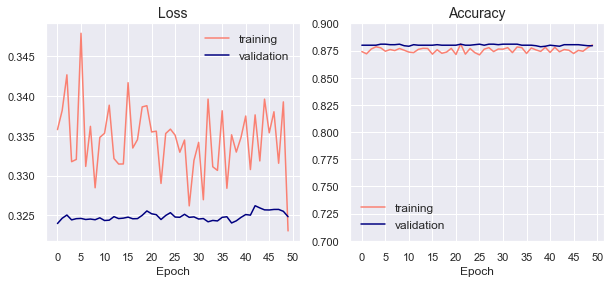

In [83]:
ax = evaluate_model.plot_loss_acc(model.history)
ax[1].set_ylim([0.7, 0.9])

In [84]:
y_predict = model.predict(X_test)
y_predict_binary = (y_predict > 0.5).astype("int32")

model.evaluate(X_test, y_test)

67/67 [==============================] - ETA: 0s - loss: 0.5588 - accuracy: 0.81 - 0s 608us/step - loss: 0.3093 - accuracy: 0.8879


[0.30927884578704834, 0.8879432678222656]

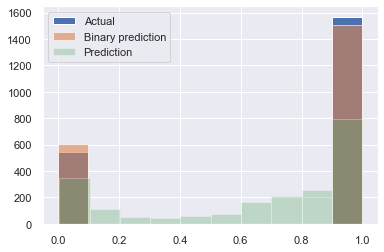

In [85]:
### Sanity check of predicted classification histogram
fig, ax = plt.subplots()
ax.hist(y_test, label='Actual')
ax.hist(y_predict_binary, alpha = 0.6, label='Binary prediction')
ax.hist(y_predict, alpha = 0.3, label='Prediction')
ax.legend()
plt.show()

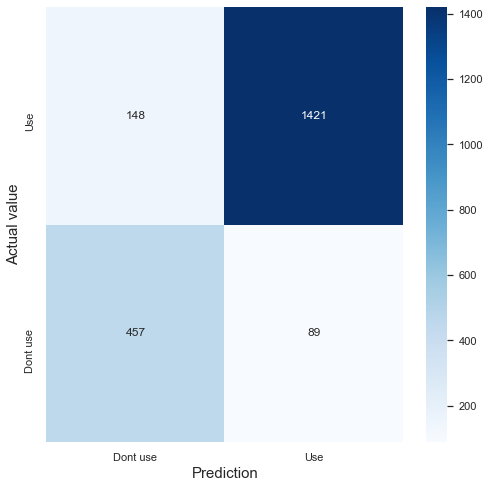

In [86]:
frac = 0.5

y_predict = model.predict(X_test)
# converting to definite classes.
y_predict_classes = (y_predict > 0.5).astype("int32")

# cutting on when the model is *really* sure.
y_predict_classes_certain = (y_predict.ravel()[(y_predict.ravel() > 1 - frac) | (y_predict.ravel() < frac)] > 0.5).astype("int32")
y_test_certain = y_test[(y_predict.ravel() > 1 - frac) | (y_predict.ravel() < frac)]

evaluate_model.plot_confusion_matrix(y_test_certain, y_predict_classes_certain, labels=['Dont use', 'Use'])

In [87]:
model.evaluate(X_test[(y_predict.ravel() > 1 - frac) | (y_predict.ravel() < frac)], y_test[(y_predict.ravel() > 1 - frac) | (y_predict.ravel() < frac)])

67/67 [==============================] - ETA: 0s - loss: 0.5588 - accuracy: 0.81 - 0s 646us/step - loss: 0.3093 - accuracy: 0.8879


[0.30927884578704834, 0.8879432678222656]

### Summary
- Successfully implemented FCN with 88.8% accuracy (when splitting classifications at p=0.5), this steadily increases to ~100% accuracy when only using classifications the model is most certain about.
- Network trains very quickly and 50 epochs almost certainly overkill, however, reducing LR on plateau (and significant levels of dropout on most layers) counteracts overfitting (as seen in the loss/accuracy plots)
- Strangely validation loss/accuracy appears to be consistently better performing than against the training set. 


In [88]:
model.save('optimal_FCN_50epoch_ReduceLRonPlateau')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: optimal_FCN_50epoch_ReduceLRonPlateau/assets
